# TOM pattern recognition from time series data 

```
Author: Gcinizwe Dlamini
```
<hr>

```
The notebook contains the following main sections : 
  1. Data preprocessing
  2. EDA
  3. Profile matrix calculation
  4. Conclusions

Main libraries used :     
- stumpy
- matrixprofile
- plotly (for visualization)
```

## 1. Install the necessary libraries

In [1]:
# !pip install scipy==1.5
# !pip install stumpy
# !pip install matrixprofile

## 2. Import libraries

In [2]:
import numpy as np
import pandas as pd
import zipfile

# for data visualization
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

# For matrix profile calculations
import stumpy

## 3. Read the data

In [8]:
cols_to_select = ['commit_datetime', 'full_name', 'total_files', 'total_added','total_removed','total_changed']
zf = zipfile.ZipFile('../Data/sample_data.zip')
repository_hist_df = pd.read_csv(zf.open('commits_data.csv'), usecols= cols_to_select,parse_dates=['commit_datetime'],index_col='commit_datetime')
repository_hist_df.head()   

,full_name,total_files,total_added,total_removed,total_changed
commit_datetime,,,,,
2021-11-12 14:59:18,xavzelada/repo_test,1,1,1,2
2021-11-12 14:27:55,xavzelada/repo_test,1,1,0,1
2021-11-08 11:39:31,xavzelada/repo_test,1,0,29,29
2021-11-08 11:38:27,xavzelada/repo_test,11,714,2,716
2021-10-22 15:21:37,xavzelada/repo_test,1,1,0,1


In [5]:
repository_hist_df.full_name.unique()

array(['xavzelada/repo_test', 'spring-projects/spring-boot',
       'grimm-auto-finance/backend', 'maxim5/webby', 'hotio/sabnzbd',
       'hotio/lidarr', 'hotio/nzbget'], dtype=object)

In [6]:
cols_to_select = ['commit_datetime', 'full_name', 'total_files', 'total_added','total_removed','total_changed']
data_path = '../Data/repositories.csv'
repository_hist_df = pd.read_csv(data_path, usecols= cols_to_select,\
                                 parse_dates=['commit_datetime'],index_col='commit_datetime')
repository_hist_df.head()

,full_name,total_files,total_added,total_removed,total_changed
commit_datetime,,,,,
2022-02-03 10:39:45,tattrung15/BookShop_Server,3,17,17,34
2021-12-24 09:29:23,tattrung15/BookShop_Server,2,5,7,12
2021-12-24 09:26:51,tattrung15/BookShop_Server,2,5,7,12
2021-12-17 08:50:50,tattrung15/BookShop_Server,1,14,0,14
2021-12-17 08:50:16,tattrung15/BookShop_Server,1,14,0,14


## 4. Sample one repository for visualisation and experimentation

In [9]:
repo_to_select = 'spring-projects/spring-boot'
df = repository_hist_df.query('full_name == @repo_to_select').sort_index()
df.drop('full_name',axis=1,inplace=True)
col_mapping = {'total_files': 'T1', 'total_added': 'T2','total_removed':'T3',
              'total_changed':'T4'}
df.rename(col_mapping, axis=1,inplace=True)
df.index = np.arange(0,len(df))
df.head()

,T1,T2,T3,T4
0,5,59,3,62
1,12,611,0,611
2,1,11,11,22
3,5,134,1,135
4,1,4,3,7


## 5. Scale the data for easy calculation of distance

In [10]:
scaler = MinMaxScaler()
df[list(df.columns)] = scaler.fit_transform(df[list(df.columns)].values)
df.head()

,T1,T2,T3,T4
0,0.016667,0.002079,0.000063,0.000814
1,0.040000,0.021535,0.000000,0.008020
2,0.003333,0.000388,0.000230,0.000289
3,0.016667,0.004723,0.000021,0.001772
4,0.003333,0.000141,0.000063,0.000092


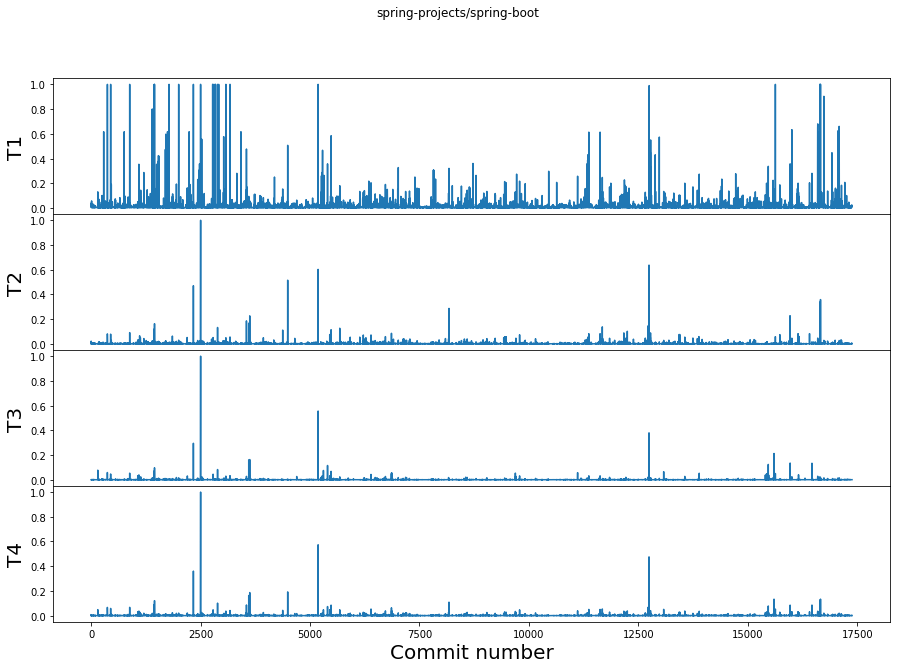

In [11]:
fig, axs = plt.subplots(df.shape[1],1,sharex=True,figsize=(15,10),gridspec_kw={'hspace': 0})
plt.suptitle(f'{repo_to_select}')
for i in range(df.shape[1]):
    axs[i].set_ylabel(f'T{i + 1}', fontsize='20')
    axs[i].set_xlabel('Commit number', fontsize ='20')
    axs[i].plot(df[f'T{i + 1}'])
# plt.savefig('multiPlot.eps')
plt.show()

## 6. Calculation of matrix profiles

In [12]:
def calc_profile_matrix(df, m=30, tot_motifs=3):
  """Function to calulate 1-dimensional matrix profiles given subsequence size (m)"""
  mps = {}  # Store the 1-dimensional matrix profiles
  motifs_idx = {}  # Store the index locations for each pair of 1-dimensional motifs (i.e., the index location of two smallest matrix profile values within each dimension)
  for dim_name in df.columns:
    mps[dim_name] = stumpy.stump(df[dim_name].astype(np.float64), m)
    motif_distance = np.round(mps[dim_name][:, 0].min(), 1)
    motifs_idx[dim_name] = np.argsort(mps[dim_name][:, 0])[:tot_motifs]
    print(f'The motif pair matrix profile value in {dim_name} is {motif_distance}')
    # motifs_idx.keys()

  return mps, motifs_idx

## 7. Plotting the Motifs

In [13]:
def plot_data(df, mps, motifs_idx, m):
  fig, axs = plt.subplots(df.shape[1] * 2,1,sharex=True,figsize=(25,15),gridspec_kw={'hspace': 0})
  for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df[dim_name].iloc[:])
    axs[k+ df.shape[1]].plot(mps[dim_name][:,0],c='green', linewidth=2)
    axs[k+ df.shape[1]].set_ylabel(f"P{k+1}", fontsize='20')
    axs[k+ df.shape[1]].axes.set_yticks([])
    axs[k].axes.set_yticks([])

    for idx in motifs_idx[dim_name]:
      axs[k].plot(df[dim_name].iloc[idx:idx+m], c='red', linewidth=2)
      axs[k].axvline(x=idx, linestyle="dashed", c='black')

  plt.savefig(f'All_data_{m}.eps')
  plt.show()

## Motifs > 2 in time series

The motif pair matrix profile value in T1 is 0.0
The motif pair matrix profile value in T2 is 0.0
The motif pair matrix profile value in T3 is 0.0
The motif pair matrix profile value in T4 is 0.0


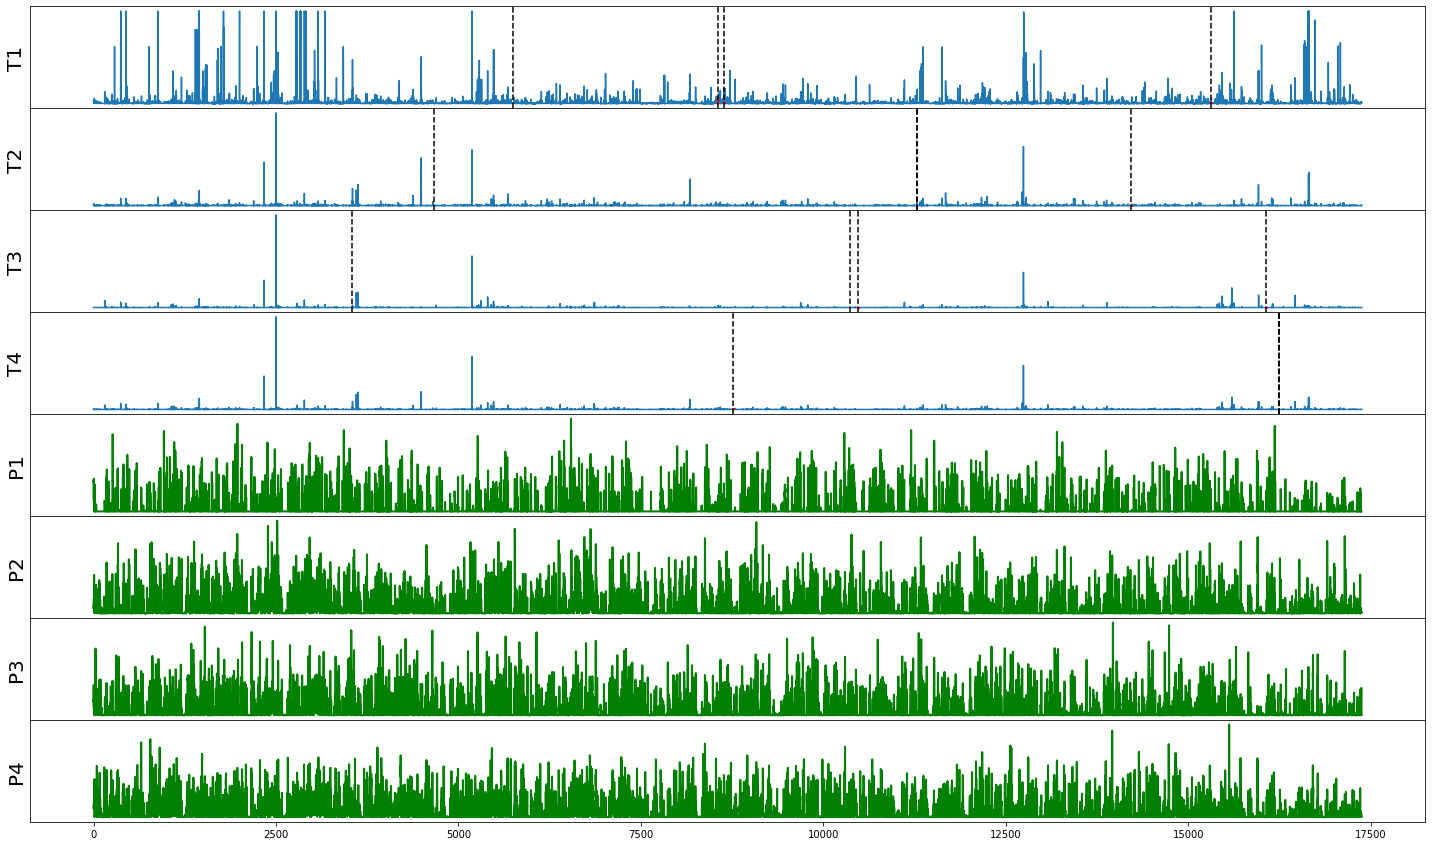

The motif pair matrix profile value in T1 is 0.0
The motif pair matrix profile value in T2 is 0.0
The motif pair matrix profile value in T3 is 0.0
The motif pair matrix profile value in T4 is 0.0


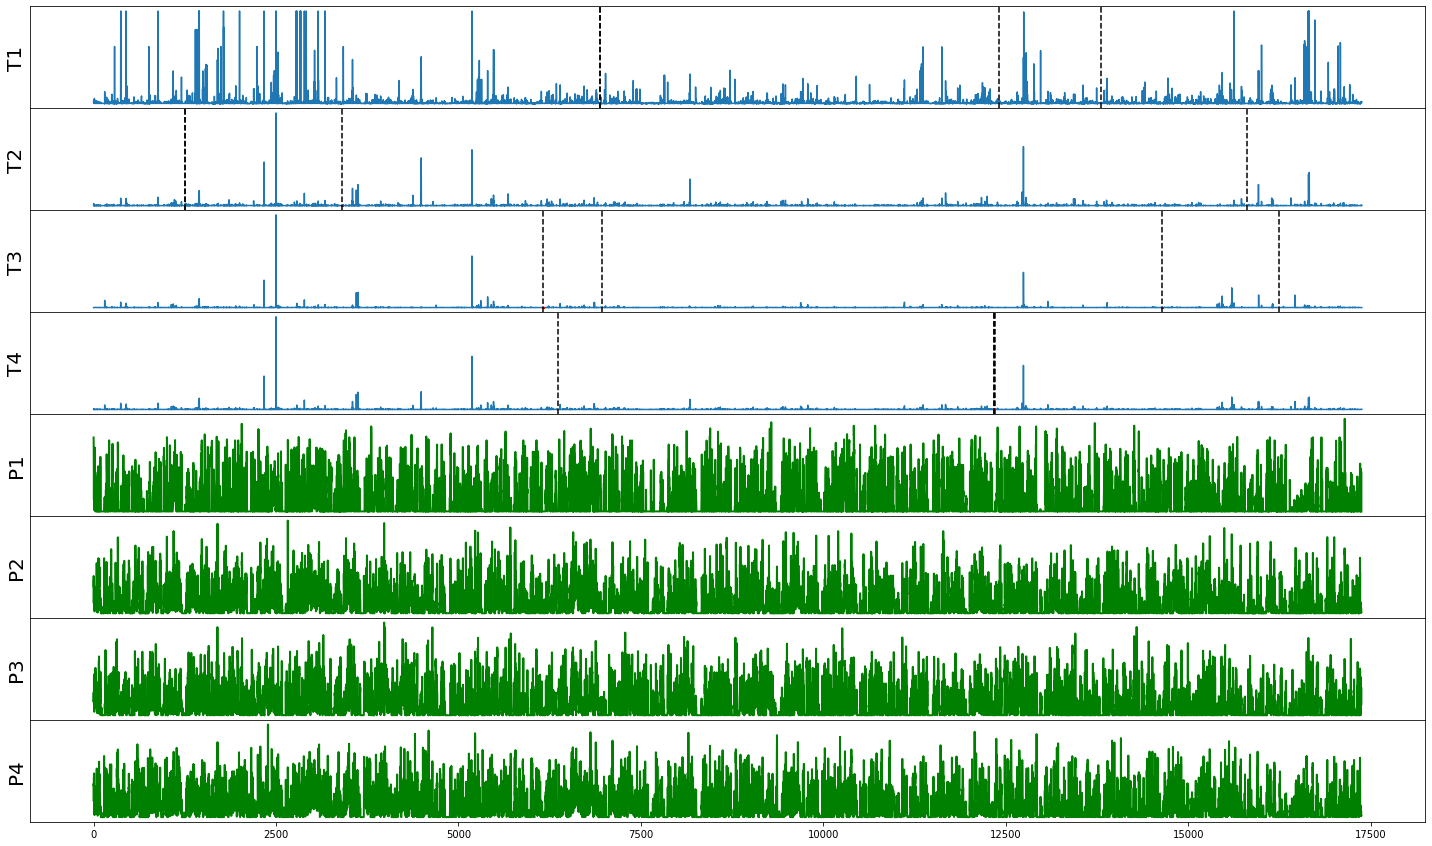

The motif pair matrix profile value in T1 is 0.0
The motif pair matrix profile value in T2 is 0.0
The motif pair matrix profile value in T3 is 0.0
The motif pair matrix profile value in T4 is 0.0


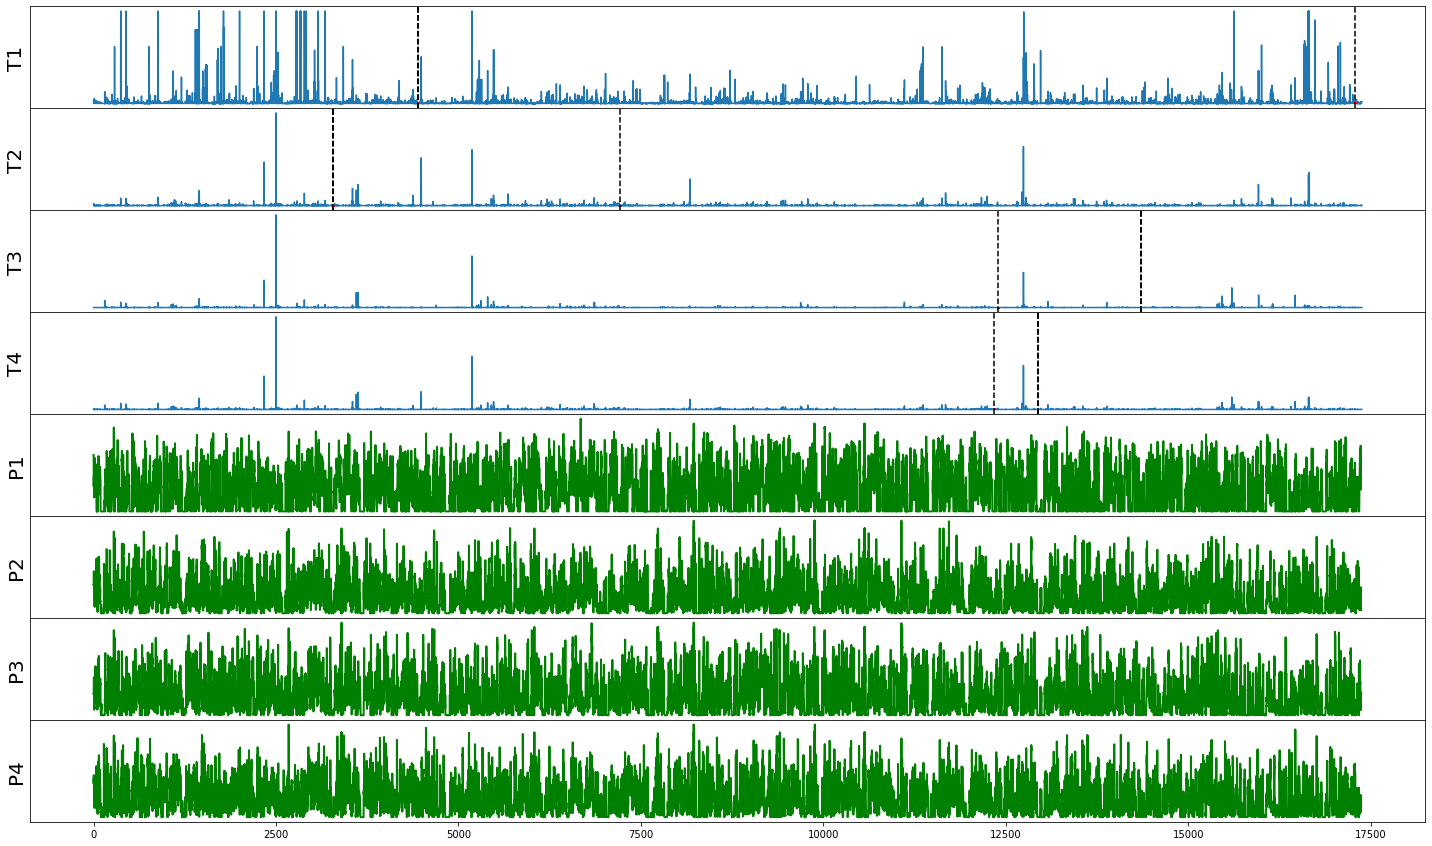

The motif pair matrix profile value in T1 is 0.0
The motif pair matrix profile value in T2 is 0.0
The motif pair matrix profile value in T3 is 0.0
The motif pair matrix profile value in T4 is 0.0


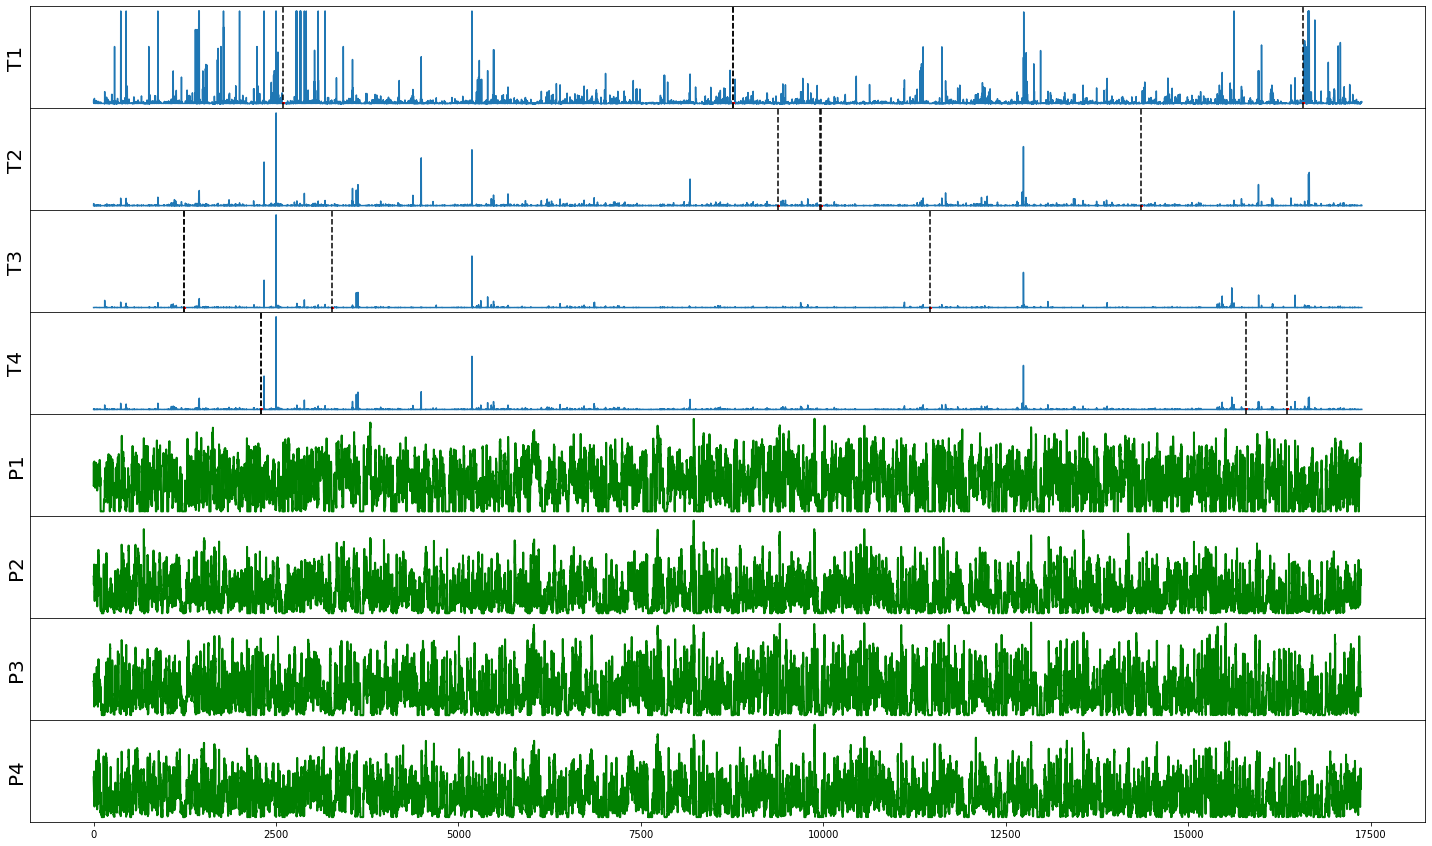

The motif pair matrix profile value in T1 is 0.0
The motif pair matrix profile value in T2 is 0.0
The motif pair matrix profile value in T3 is 0.0
The motif pair matrix profile value in T4 is 0.0


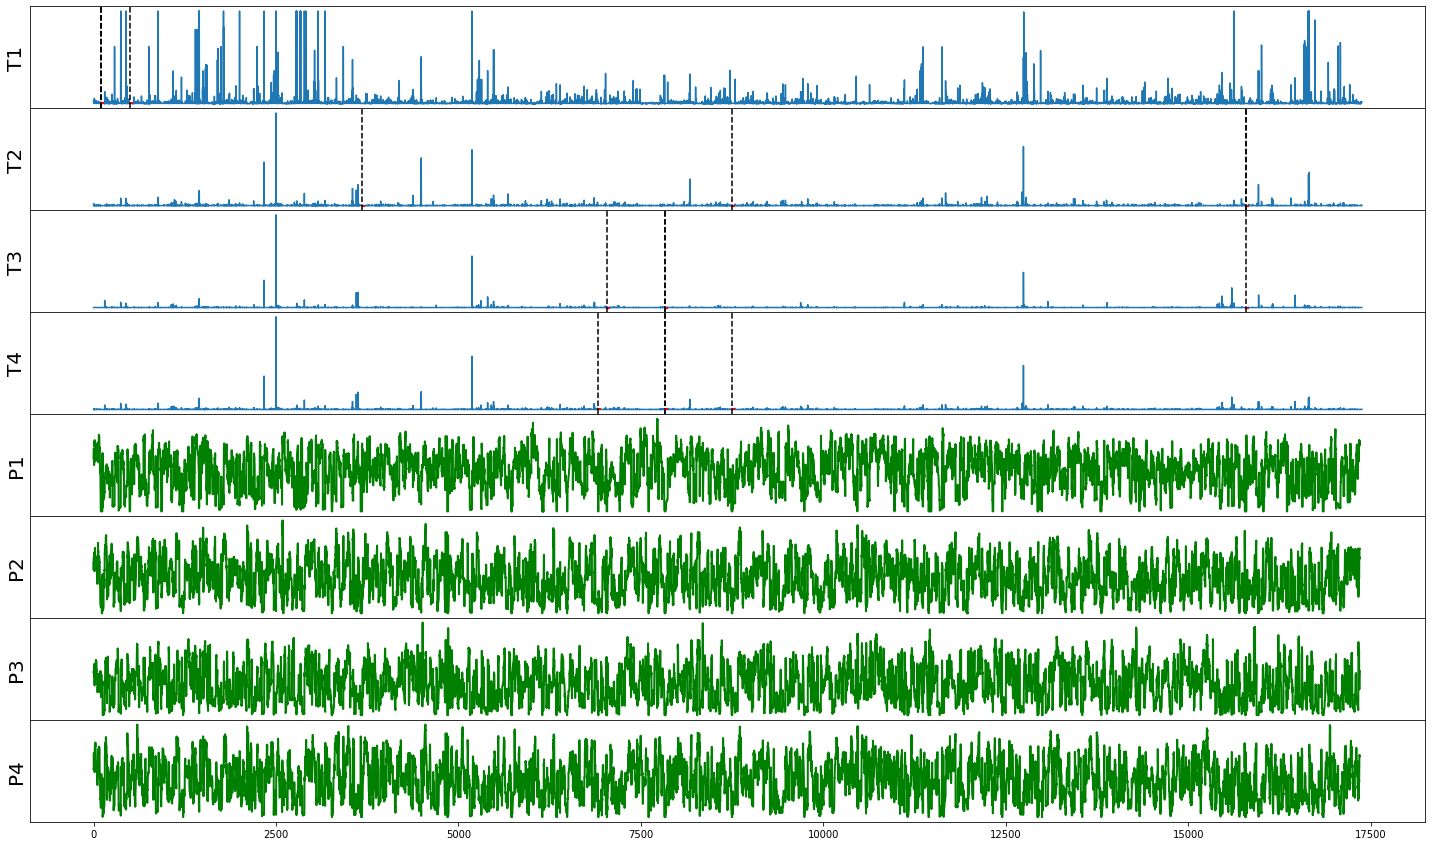

In [14]:
for m  in [5, 7, 10, 14, 30]:
  mps, motifs_idx = calc_profile_matrix(df,m,4)
  plot_data(df, mps, motifs_idx, m)

## 8. Multi-dimensional Matrix Profiles

In [15]:
m = 7
mps, indices = stumpy.mstump(df, m)

Consequently, the “k-dimensional motif” can be found by locating the lowest values in the corresponding k-dimensional matrix profile, mps:

In [16]:
motifs_idx = np.argmin(mps, axis=1)
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

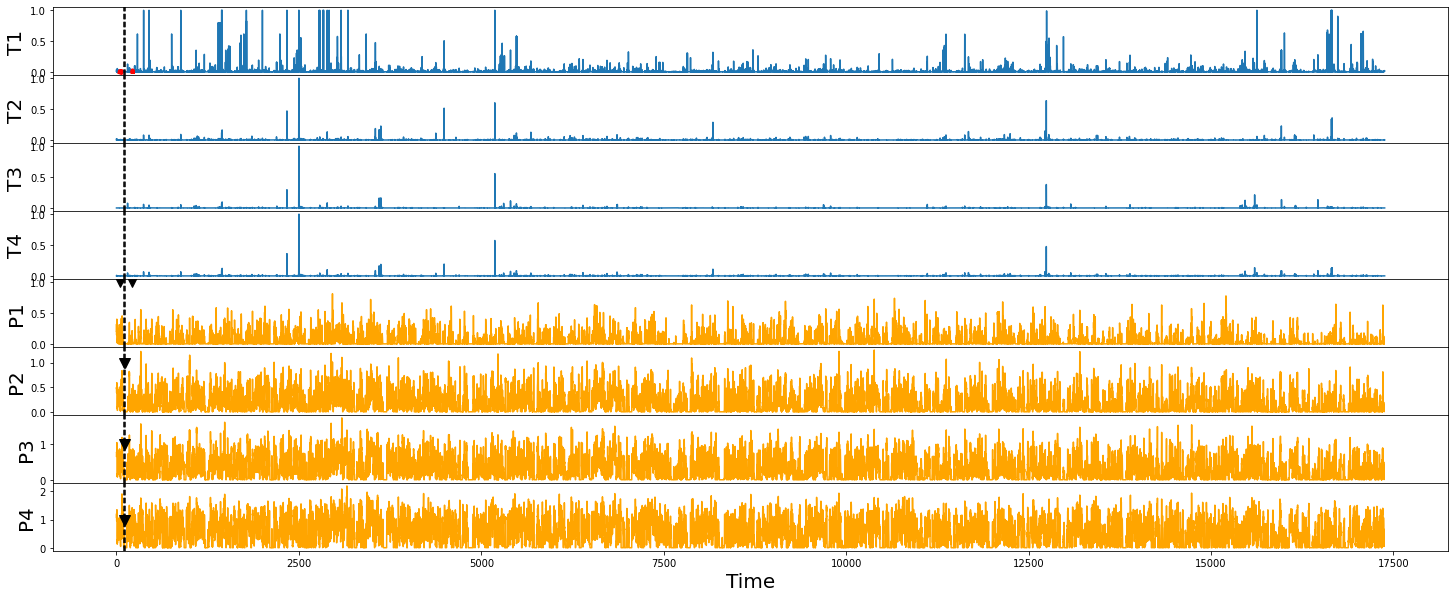

In [17]:
fig, axs = plt.subplots(mps.shape[0] * 2,1,sharex=True,figsize=(25,10),gridspec_kw={'hspace': 0})
for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[2], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[2], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[2], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=nn_idx[2], linestyle="dashed", c='black')
    
    axs[k].plot(df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=5)
    axs[k].plot(df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
   
    axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
    axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

plt.show()

## Choosing value of $k$ in multidimentional 

approach is to turn this into a classic elbow/knee finding problem by plotting the minimum matrix profile value in each dimension against 𝑘 and then you look for the “turning point”

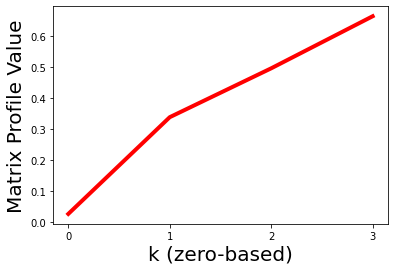

In [ ]:
plt.plot(mps[range(mps.shape[0]), motifs_idx[:]], c='red', linewidth='4')
plt.xlabel('k (zero-based)', fontsize='20')
plt.ylabel('Matrix Profile Value', fontsize='20')
plt.xticks(range(mps.shape[0]))
plt.show()

# Matrixprofile lib approach 

In [18]:
cols_to_select = ['commit_datetime', 'full_name', 'total_files', 'total_added','total_removed','total_changed'	]
data_path = '../Data/repositories.csv'
repository_hist_df = pd.read_csv(data_path, usecols= cols_to_select,\
                                 parse_dates=['commit_datetime'],index_col='commit_datetime')


repo_to_select = 'brianchandotcom/liferay-portal'
df = repository_hist_df.query('full_name == @repo_to_select').sort_index()
df.drop('full_name',axis=1,inplace=True)
col_mapping = {'total_files': 'T1', 'total_added': 'T2','total_removed':'T3',
              'total_changed':'T4'}
df.rename(col_mapping, axis=1,inplace=True)
df.head()

,T1,T2,T3,T4
commit_datetime,,,,
2020-02-19 22:58:31,7,395,0,395
2020-02-20 03:20:15,2,6,4,10
2020-02-20 03:32:14,1,18,35,53
2020-02-20 03:36:01,3,6,6,12
2020-02-20 03:50:12,1,49,25,74


In [19]:
df.drop(['T1','T2','T3'],axis=1,inplace=True)
df.head()

,T4
commit_datetime,
2020-02-19 22:58:31,395
2020-02-20 03:20:15,10
2020-02-20 03:32:14,53
2020-02-20 03:36:01,12
2020-02-20 03:50:12,74


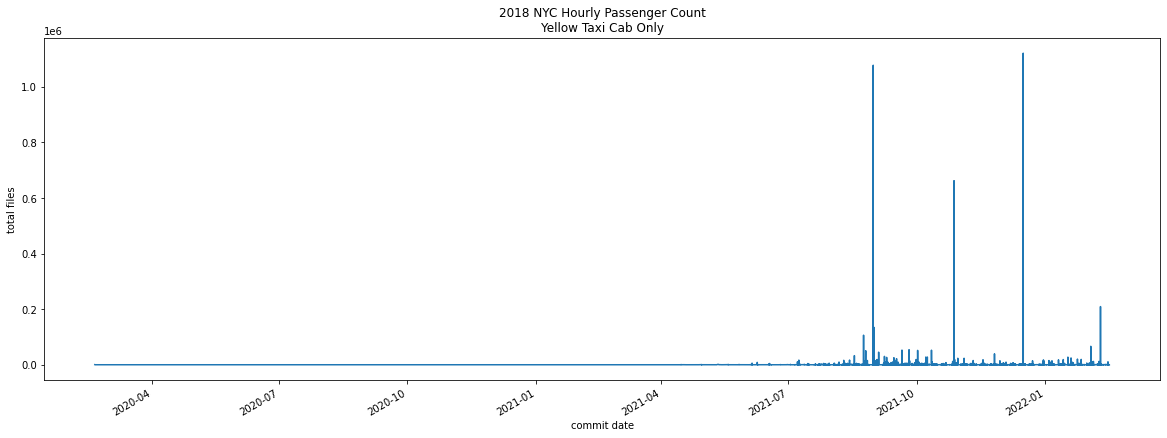

In [20]:
df.plot(figsize=(20,7), legend=None, title='2018 NYC Hourly Passenger Count\nYellow Taxi Cab Only')
plt.xlabel('commit date')
plt.ylabel('total files')
plt.show()

In [21]:
windows = [
    ('4 Hours', 4),
    ('8 Hours', 8),
    ('12 Hours', 12),
    ('24 Hours', 24),
    ('7 Days', 7 * 24)
]

profiles = {}
motifs = {}

for label, window_size in windows:
    profile = mp.compute(df['T4'].values, window_size)
    key = '{} Profile'.format(label)
    profiles[key] = profile
    

NameError: name 'mp' is not defined

In [ ]:
res = mp.analyze(df['T4'].values, 30 * 24)

In [ ]:
#Plot the signal data
fig, axes = plt.subplots(6,1,sharex=True,figsize=(15,10))

for ax_idx, window in enumerate(windows):
    key = '{} Profile'.format(window[0])
    profile = profiles[key]
    axes[ax_idx].plot(profile['mp'])
    axes[ax_idx].set_title(key)

plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()

In [ ]:
for label, window_size in windows:
    key = '{} Profile'.format(label)
    profiles[key] = mp.discover.discords(profiles[key], k=5)
    
    window_size = profiles[key]['w']
    mp_adjusted = np.append(profiles[key]['mp'], np.zeros(window_size - 1) + np.nan)
    
    plt.figure(figsize=(15, 7))
    ax = plt.plot(df.index.values, mp_adjusted)
    plt.title(key)
    
    for start_index in profiles[key]['discords']:
        x = df.index.values[start_index:start_index+window_size]
        y = mp_adjusted[start_index:start_index+window_size]
        plt.plot(x, y, c='r')
    
    plt.show()

In [ ]:
!pip install git+https://github.com/matrix-profile-foundation/matrixprofile

In [ ]:
cols_to_select = ['commit_datetime', 'full_name', 'total_files', 'total_added','total_removed','total_changed'	]
data_path = '../Data/repositories.csv'
repository_hist_df = pd.read_csv(data_path, usecols= cols_to_select,\
                                 parse_dates=['commit_datetime'],index_col='commit_datetime')


repo_to_select = 'brianchandotcom/liferay-portal'
df = repository_hist_df.query('full_name == @repo_to_select').sort_index()
df.drop('full_name',axis=1,inplace=True)
col_mapping = {'total_files': 'T1', 'total_added': 'T2','total_removed':'T3',
              'total_changed':'T4'}
df.rename(col_mapping, axis=1,inplace=True)
df.head()

,T1,T2,T3,T4
commit_datetime,,,,
2021-12-21 14:29:43,4,128,0,128
2021-12-21 15:02:48,25,878,8,886
2021-12-21 15:10:30,22,763,0,763
2021-12-21 15:20:39,25,875,0,875
2021-12-21 15:25:48,70,2516,8,2524


In [ ]:
mp.analyze(df.values)